# **PROJECT:** BIODIVERSITY OF UNITED STATES NATIONAL PARKS

## I. Introduction

Biodiversity is defined as the variability among living organisms in an ecosystem. Measuring biodiversity is important since it is the foundation of eco-system services and also is linked to human well-being. Biodiversity can be measured at many different levels including genetic, species, community, and ecosystem. 

The dataset used in this project is available on Kaggle and contributed by National Park Service. It provides information on the presence and status of species in our national parks.

For more information about the dataset, please go to: <br>
https://www.kaggle.com/nationalparkservice/park-biodiversity?select=species.csvhttps://www.kaggle.com/nationalparkservice/park-biodiversity?select=species.csv

One way to measure the biodiversity of these four national parks is to assess species richness of an ecosystem, or, in other words, the number of distinct species within these local communities. Another measurement of biodiversity is the evenness, which is the equality of species living in a partical natural habitat. In summary, an area with a variety of species which are relatively equal in abundance is considered a healthy and biodiverse ecosystem. 

This project is part of Codecademy Data Science Career Path and inspired by a short report by Noah Snizik. 

**Reference:** 
1. Millennium Ecosystem Assessment, 2005. Ecosystems and Human Well-being: Biodiversity Synthesis. World Resources Institute, Washington, DC. <http://www.millenniumassessment.org/documents/document.354.aspx.pdf>


## II. Analysis

This part will be divided into 3 sections addressing different questions:
1. Prepocess the data
2. Exploratory Data Analysis (EDA)
3. Hypothesis Testings

In [1]:
## Import essential libraries for analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kendalltau, distributions, chi2_contingency

## Import libraries for display
from IPython.display import display, HTML

## Other libraries
import warnings
warnings.filterwarnings('ignore')

## Change graphical settings
sns.set_style('darkgrid')
%matplotlib inline

### Section 1: Preprocess the data

In [2]:
## Load datasets using pandas
park = pd.read_csv('parks.csv')
species = pd.read_csv('species.csv', low_memory=False)

After loading the data into this Jupyter Notebook, I encountered a problem that there is an extra column "Unnamed: 13" which contains some data of the column "Conservation Status". This is probably due to delimiter issues in the `.csv` file. There are three values which shouldn't be under "Conservation Status" including "Breeder", "Migratory", "Resident". Thus, I have to replace these with correct values taken from the extra column.

Then, I will drop some unused columns in the two datasets.

In [3]:
## Replace misplaced values with values from the extra column
species['Conservation Status'] = species.apply(
    lambda row: row['Unnamed: 13'] 
    if row['Conservation Status'] == 'Resident' 
    or row['Conservation Status'] == 'Breeder' 
    or row['Conservation Status'] == 'Migratory' 
    else row['Conservation Status'], axis=1
)

## Drop unused columns in this project
park.drop(labels=['Park Code', 'Acres'], inplace=True, axis=1)
species.drop(
    labels=['Species ID', 'Order', 'Family', 'Record Status', 'Occurrence', 'Seasonality', 'Unnamed: 13'],
    inplace=True, axis=1
)

park.columns

Index(['Park Name', 'State', 'Latitude', 'Longitude'], dtype='object')

After dropping some unused columns, the two datasets are left with these variables:
- `Park Name`: Official park names and where the species appear.
- `Latitude`: Latitude of the park (centroid).
- `Longtitude`: Longitude of the park (centroid).
- `Category`: One of Mammal, Bird, etcetera.
- `Scientific Name`: Official scientific name.
- `Common Name`: Usual common name(s) for the species. Comma-delimited.
- `Nativeness`: Whether the species is native to the area or a non-native/invasive.
- `Abundance`: Commonality of sightings.
- `Conservation Status`: IUCN species conservation status.

In [4]:
## Check for missing values
species.isna().sum()

Park Name                   0
Category                    0
Scientific Name             0
Common Names                0
Nativeness              25045
Abundance               42942
Conservation Status    114541
dtype: int64

There're lots of missing values in three columns: `Nativeness` `Abundance` and `Conservation Status`. Yet, after having looked into these rows, I decided not to do anything with them since they were probably left blank on purpose. Any effort to replace the null ones may lead to misleading conclusions.

In [5]:
## Check for duplicates
# species[species.duplicated()]

There seems to be no duplicate in the dataset since the scientific names are all different. Thus, I'll keep all the rows. Next, I'll change the columns name following Python variable names rules.

In [6]:
## Change columns name following Python variable names rules
park.columns=['park_name', 'state', 'latitude', 'longtitude']
species.columns=[
    'park_name', 'category', 'scientific_name',
    'common_names', 'nativeness', 'abundance', 'conservation_status'
]

To make it easier and more convenient to work with the data, I'll merge these two datasets. The merged dataset should have the same number of rows as the `species` dataframe: 119,248 observations. Also, I will take a glance at the first few rows to check if there's any problem arising.

In [7]:
## Merge two dataframes
park_species = pd.merge(species, park, on='park_name', how='outer')
len(park_species)

119248

The names of the parks are quite long, so I decided to rid the names of "National Park." The `conservation_status` and `abundance` seem to be an ordinal variable, so I will convert it into an Category object.

In [8]:
## Replace 'National Park' with an empty string
park_species.park_name = park_species.park_name.str.replace('National Park', '')
park_species.head()

## Convert `conservation_status` to Category object
park_species.conservation_status = pd.Categorical(
    park_species.conservation_status,
    categories=[
        'Under Review', 'In Recovery', 'Species of Concern',
        'Proposed Threatened', 'Threatened', 'Proposed Endangered',
        'Endangered', 'Extinct'],
    ordered=True
)

## Convert `abundance` to Category object
park_species.abundance = pd.Categorical(
    park_species.abundance,
    categories=['Rare', 'Occasional', 'Uncommon', 'Common', 'Abundant'],
    ordered=True
)

In order to assess the relation between biodiversity and location, I create a column named Zone and put different parts into three different zones: `Arctic`, `Temperate` and `Tropical`.

In [9]:
## Group locations based on zones
park_species['zone'] = park_species.apply(
    lambda row: 'Arctic' if row.latitude > 66.5 else (
        'Temperate' if 66.5 > row.latitude > 35 else (
            'Subtropical' if 35 > row.latitude > 23.43 else 'Tropical')),
    axis=1)

park['zone'] = park.apply(
    lambda row: 'Arctic' if row.latitude > 66.5 else (
        'Temperate' if 66.5 > row.latitude > 35 else (
            'Subtropical' if 35 > row.latitude > 23.43 else 'Tropical')),
    axis=1)

### Section 2: Explore and visualize the data

In this section, I will aim to conduct Exploratory Data Analysis to answer the following questions: 
1. Which national park has the largest number of distinct species?
2. Which category has the largest number of species?
3. What are the US national park species richness rankings?
4. Which national park has the most species of concern and endangered species? 
5. Which groups has the largest number of species in conservation? 

#### Park Locations and Comparisons of Species Richness

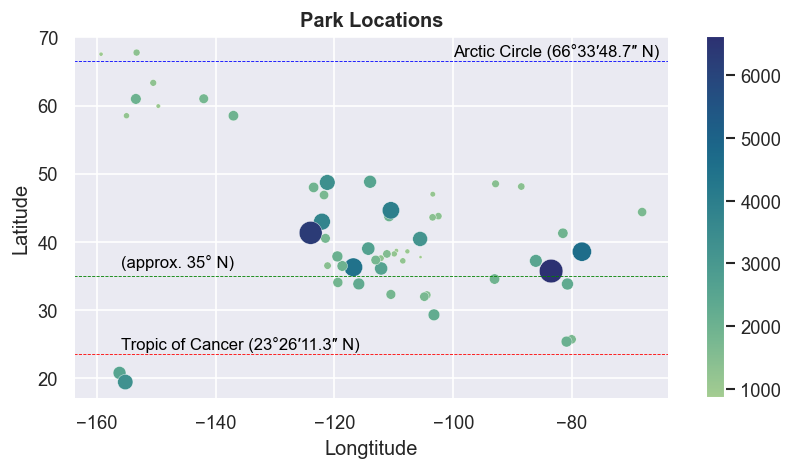

<Figure size 432x288 with 0 Axes>

In [10]:
## Group by park_name and latitude
lat_park = park_species.groupby(['park_name', 'latitude', 'longtitude', 'zone']).scientific_name.count().reset_index()
lat_park.rename(columns={'scientific_name':'species_count'}, inplace=True)
lat_park.sort_values(by='latitude').reset_index()

## Plot a scatter to visualize the park locations and the number of species in each park
sns.set()
plt.figure(figsize=(8,4), dpi=120)
ax = sns.scatterplot(
    data=lat_park, x='longtitude', y='latitude', hue='species_count',
    legend=False, palette='crest', sizes=(0, 200),
    size='species_count'
)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.title('Park Locations', weight='bold')

## Add a colorbar for color-size references
norm = plt.Normalize(lat_park.species_count.min(), lat_park.species_count.max())
sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
ax.figure.colorbar(sm)

## Draw three lines seperating the climate zones
line1 = plt.axhline(y=66.5, color='blue', linestyle='dashed', linewidth=0.5)
plt.text(x=-100, y=67.2, s='Arctic Circle (66°33′48.7″ N)', color='black', weight='light', size=10)

line2 = plt.axhline(y=23.43, color='red', linestyle='dashed', linewidth=0.5)
plt.text(x=-156, y=24.2, s='Tropic of Cancer (23°26′11.3″ N)', color='black', weight='light', size=10)

line3 = plt.axhline(y=35, color='green', linestyle='dashed', linewidth=0.5)
plt.text(x=-156, y=36.2, s='(approx. 35° N)', color='black', weight='light', size=10)

plt.show()
plt.clf()

The scatter plot shows that most of the national parks with large numbers of species are located in the ***Temperate Zone*** whose moderate rainfall spread across the year or portion of the year, mild to warm summers and cool to cold winters. This climate zone also houses the top biodiverse national parks in the US including ***Redwood*** in the western United States and ***Great Smoky Mountains*** in the southeastern part of the nation. In addition, based on the size and the color of the points, we can see that most species rich parks are on the west side of the contiguos United States. 

In the other two major climate zones, the two national parks in Hawaii, ***Haleakala*** and ***Hawaii Volcanos*** also make the list of parks with a wide variety of species. On the contrary, located roughly at the same longtitude but at a much higher latitude, above the Arctic Circle, ***Kobuk Valley*** and ***Gates of Alaska*** are two of the least biodiverse national parks in the United States. 

Here are the top 5 and the bottom 5 national parks based on species richness:

| Top 5 | Bottom 5 |
|-------|----------|
|1. Great Smoky Mountains, TN, NC| 56. Dry Tortugas, FL|
|2. Redwood, CA| 55. Petrified Forest, AZ|
|3. Shennandoah, VA| 54. Great Sand Dunes and Preserve, CO|
|4. Death Valley, CA, NV| 53. Kobuk Valley, AK|
|5. Yellowstone, WY, MT, ID| 52. Arches, UT|

*(See Appendix A for the complete rankings)*

#### Species by Category

In this part, I will look into the categories of species in 56 US national parks and find out which categories have the most number of species and more.

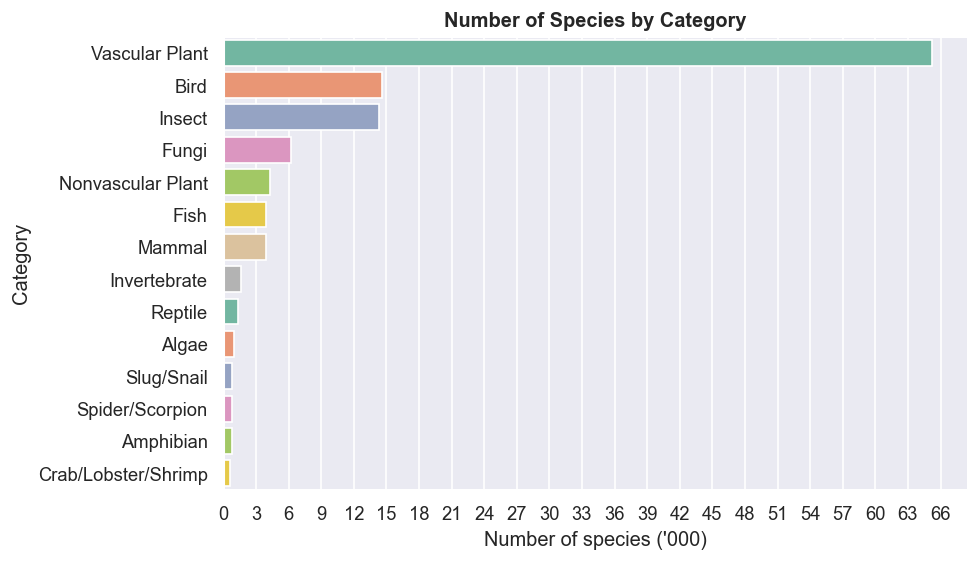

<Figure size 432x288 with 0 Axes>

In [11]:
## Group data by category
species_cat = park_species.groupby('category').scientific_name.count().reset_index()
species_cat.columns = ['category', 'species_count']

species_cat.sort_values(by='species_count', inplace=True, ascending=False)

## Plot a bar chart to compare the number of species of different categories
plt.figure(figsize=(8,5), dpi=120)
sns.barplot(x='species_count', y='category', data=species_cat, palette='Set2')
plt.xticks(range(0, 67000, 3000), labels=[int(i/1000) for i in range(0, 67000, 3000)], rotation=0)
plt.title('Number of Species by Category', weight='bold')
plt.xlabel('Number of species (\'000)')
plt.ylabel('Category')
plt.show()
plt.clf()

Taking a glance at the chart, we see that ***Vasular Plant*** is the largest group whose more than 63,000 species recored across the national parks, followed by  ***Bird*** and ***Insect***, both with nearly 15,000 species each. On the other hand, ***Algae, Slug/Snail, Spider/Scorpion, Amphibian and Crab/Lobster/Shrimp*** in these national parks are quite rare compared to other categories, fewer than 1,000 species each.

#### US National Parks Biodiversity Rankings

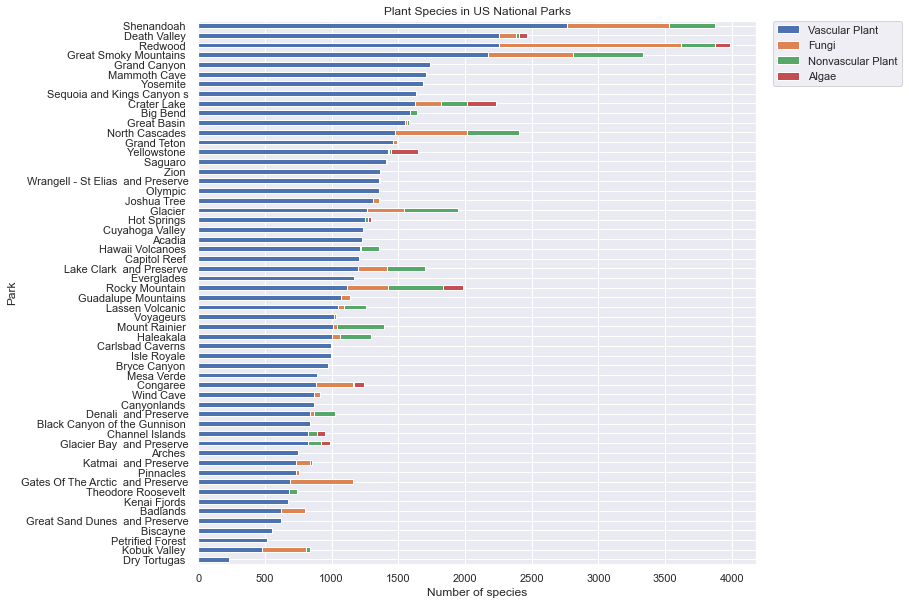

<Figure size 432x288 with 0 Axes>

In [12]:
## Group data by park_name and category
cat_park = park_species.groupby(['park_name', 'category']).scientific_name.count().reset_index()
pivoted_cat_park = pd.pivot_table(
    data=cat_park, index='park_name',
    columns='category',
    values='scientific_name'
)

## Create a new dataframe for number of species
plant_park = pivoted_cat_park.filter(['Vascular Plant', 'Fungi', 'Nonvascular Plant', 'Algae'], axis=1)

## Sort data based on conservation status - Changing this one will result in a different chart
plant_park.sort_values(by='Vascular Plant', inplace=True)

## Plot a bar plot to compare the total numbers of plant species in each park
plant_park.plot(kind='barh', stacked=True, figsize=(10,10))
plt.legend(bbox_to_anchor=(1.02, 1.01))
plt.title('Plant Species in US National Parks')
plt.ylabel('Park', fontsize=12)
plt.xlabel('Number of species', fontsize=12)
plt.show()
plt.clf()

***Redwood*** (in California) is the most biodiverse national park in terms of plant species. This is where visitors can observe a wide range of plants with over 2,000 species of vascular plants, more than 1,000 species of fungi. Followed by ***Shenandoah*** (in Virginia) where more than 2,500 vascular plants are recorded. On the other hand, ***Dry Tortugas*** (in Florida) is the least biodiverse national park in terms of plant species where you can find only fewer than 300 species of vascular plants. 

Here are the top 5 and the bottom 5 national parks based on plant species richness:

| Top 5 | Bottom 5 |
|-------|----------|
|1. Redwood, CA| 56. Dry Tortugas, FL|
|2. Shennandoah, VA| 55. Petrified Forest, AZ|
|3. Great Smoky Mountains, TN, NC| 54. Biscayne, FL|
|4. Death Valley, CA, NV| 53. Great Sand Dunes and Preserve, CO|
|5. North Cascades, WA| 52. Kenai Fjords, AK|


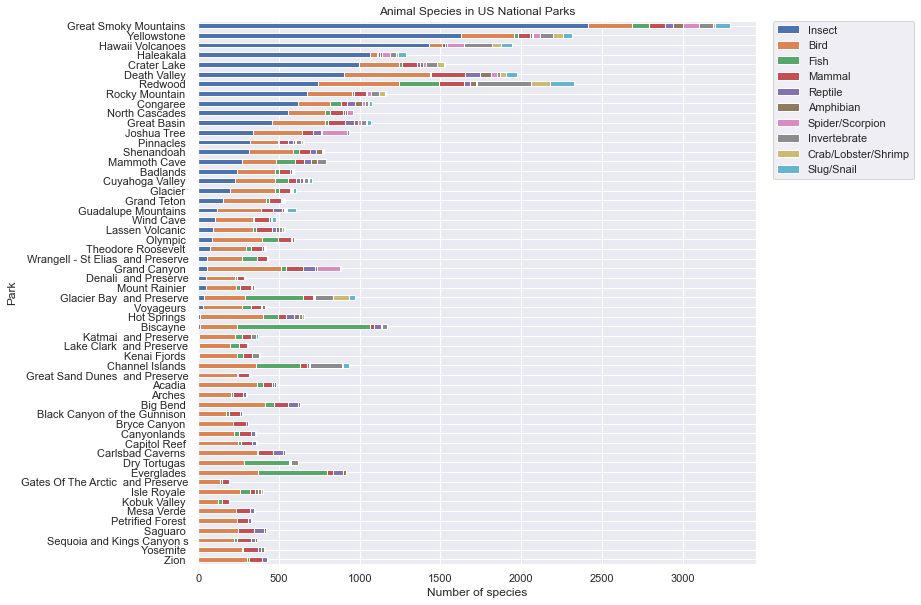

<Figure size 432x288 with 0 Axes>

In [13]:
## Create a new dataframe for number of species
animal_park = pivoted_cat_park.filter(
    ['Insect', 'Bird', 'Fish', 'Mammal', 'Reptile', 'Amphibian',
     'Spider/Scorpion', 'Invertebrate', 'Crab/Lobster/Shrimp', 'Slug/Snail'], axis=1)

## Sort data based on conservation status - Changing this one will result in a different chart
animal_park.sort_values(by='Insect', inplace=True, axis=0, ascending=False)

## Plot a bar plot to compare the total numbers of animal species in each park
animal_park.plot(kind='barh', stacked=True, figsize=(10,10))
plt.legend(bbox_to_anchor=(1.02, 1.01))
plt.title('Animal Species in US National Parks')
plt.ylabel('Park', fontsize=12)
plt.xlabel('Number of species', fontsize=12)
plt.gca().invert_yaxis()
plt.show()
plt.clf()

Speaking of the animals' world, ***Great Smoky Mountains*** (along the Tennessee–North Carolina border) tops the chart with more than 3,000 animal species, among them are 2,500 insect species. As for bird, ***Death Valley*** (in southwestern California) is home to the largest population of birds with more than 1,000 species, followed by ***Redwood*** (also in California) where nearly 1,000 species live.

***Biscanye*** (in Florida), ***Everglades*** (in Florida), ***Glacier Bay and Preserve*** (in Alaska), ***Dry Tortugas*** (in Florida) and ***Channel Islands*** (in California) are the five national parks whose largest fish population of all.

Also, it should be noted that there's no insect in nearly half of the national parks, which is surprising and worth investigating. However, due to the limitations of this dataset, I will not able to shed a light on this absence of them.

Here below are the top 5 and bottom 5 national parks in terms of animal species richness:

| Top 5 | Bottom 5 |
|-------|----------|
|1. Great Smoky Mountains, TN, NC| 56. Gates of the Arctic and Preserve, AK|
|2. Redwood, CA | 55. Kobuk Valley, AK|
|3. Yellowstone, WY, MT, ID| 54. Denali and Preserve, AK|
|4. Death Valley, CA, NV| 53. Black Canyon of the Gunnison, CO|
|5. Hawaii Volcanoes, HI| 52. Arches, UT|

Alaska appearring three times on the Bottom 5 chart is understandable since it's in one of the coldest region on Earth.

#### Species in conservation in US national parks

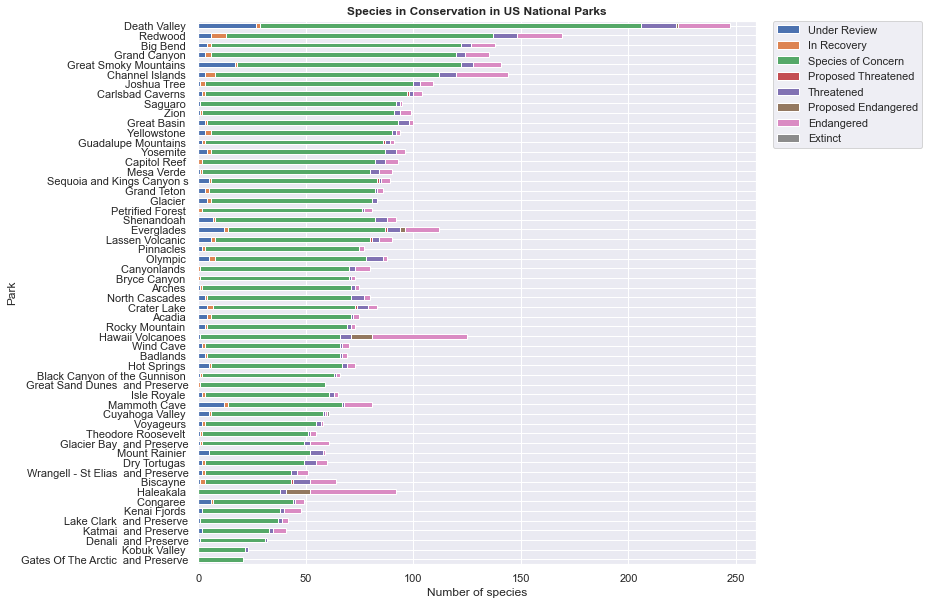

<Figure size 432x288 with 0 Axes>

In [14]:
## Group data by park_name and conservation status
cons_park = park_species.groupby(['park_name', 'conservation_status']).scientific_name.count().reset_index()
pivoted_cons_park = pd.pivot_table(
    data=cons_park, index='park_name',
    columns='conservation_status',
    values='scientific_name'
)

## Sort data based on conservation status - Changing this one will result in a different chart
pivoted_cons_park.sort_values(by='Species of Concern', inplace=True)

## Plot a bar chart to visualize the data
pivoted_cons_park.plot(kind='barh', stacked=True, figsize=(10,10))
plt.legend(bbox_to_anchor=(1.02, 1.01))
plt.title('Species in Conservation in US National Parks', weight='bold')
plt.ylabel('Park', fontsize=12)
plt.xlabel('Number of species', fontsize=12)
plt.show()
plt.clf()

Across 56 national parks in this dataset, most species in conservation are classified as 'Species of Concern'. This refers to species whose number of individuals are commonly declining or appear to be in need of concentrated conservation actions. Also, endangered species can be found in most national parks, which is understandable since nationals are established to protect wildlife as well as conserve biodiversity. 

Among the parks, the top 5 locations whose most species in conservation (regardless of status) includes ***Death Valley*** (in southwestern California), ***Redwood*** (in California), ***Channel Islands*** (in California), ***Great Smokey Mountains*** (along the Tennessee–North Carolina border) and ***Big Bend*** (in Texas), and ***Grand Canyon*** (in Arizona) is the extra name on the list. 

| Species of Concern - Top 5  | Endangered Species - Top 5  |
|-------|----------|
|1. Death Valley, CA, NV| 1. Hawaii Volcanoes, HI|
|2. Redwood, CA)| 2. Haleakala, HI|
|3. Big Bend, TX| 3. Channel Islands, CA|
|4. Grand Canyon, AZ| 4. Death Valley, CA, NV|
|5. Great Smoky Mountains, TN, NC| 5. Redwood, CA|

#### Species in conservation by category

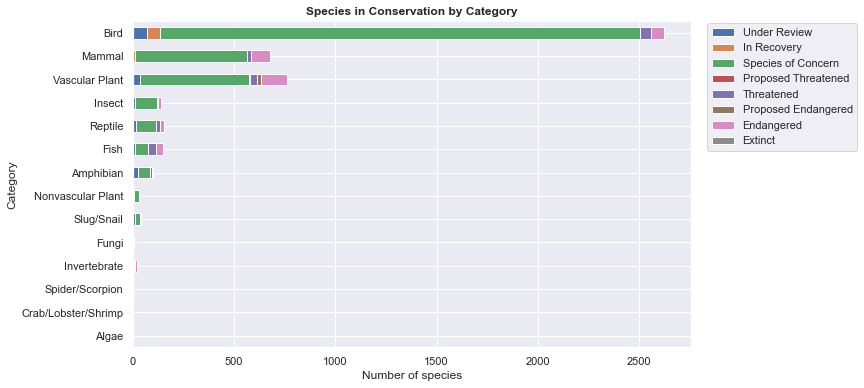

<Figure size 432x288 with 0 Axes>

In [15]:
## Group data by category and conservation status
cons_cat = park_species.groupby(['category', 'conservation_status']).scientific_name.count().reset_index()
pivoted_cons_cat = pd.pivot_table(
    data=cons_cat, index='category',
    columns='conservation_status',
    values='scientific_name'
)

## Sort data based on conservation status - Changing this one will result in a different chart
pivoted_cons_cat.sort_values(by='Species of Concern', inplace=True)

## Plot a bar chart to visualize the data
pivoted_cons_cat.plot(kind='barh', stacked=True, figsize=(10,6))
plt.legend(bbox_to_anchor=(1.02, 1.01))
plt.title('Species in Conservation by Category', weight='bold')
plt.ylabel('Category', fontsize=12)
plt.xlabel('Number of species', fontsize=12)
plt.show()
plt.clf()

Above is a bar chart illustrating the number of species in conservation grouped by category. ***Bird*** ranks number 1 on the chart with more than 2,500 species in conservation. Among them, approximately 90% are classified as species of concern. Endangered species account for around 3.7% of the population. 

Come second is **Vascular Plant** with morethan 500 species in conservation. This group also contains the largest number of endangered species, around 200. Third place on the chart belongs to **Mammal** whose most species are also classified as species of concern. 

On the hand, **Algae, Crab/Lobster/Shrimp and Spider/Scorpion** are the three groups that have no species in conservation. This could be either due to lack of information or the abundance of the species.

### Section 3: Hypothesis Testings

#### 1. Is there an association between location and species richness?

After conducting the EDA, I wondered if there was a relation between location of species richness since I noted that the parks whose high concentrations of species are located within a region at -130 to -100 degrees longtitude and at 35 to 50 degrees latitude, which is also dubbed the Western United States. Also, I noted that the lower the latitude, the higher the species richness is. To cite an example, Hawaii and Alaska are at the similar longtitude, yet, the two national parks in Hawaii have a much higher species richness. 

Since the distribution of `species_count` is highly right skwed, Kendall's Tau will be used to calculate the correlation coefficient. *(See Appendix B for a complete set of distributions)*

In [16]:
## Calculate correlation coefficient using Kendall's Tau
tau_stats_lat, pval1 = kendalltau(lat_park.latitude, lat_park.species_count)

print(f'Tau Correlation Coeff 1: {tau_stats_lat}; P-value: {pval1}')

tau_stats_lon, pval2 = kendalltau(lat_park.longtitude, lat_park.species_count)
print(f'Tau Correlation Coeff 2: {tau_stats_lon}; P-value: {pval2}')

Tau Correlation Coeff 1: -0.12873864879884334; P-value: 0.16165960252469547
Tau Correlation Coeff 2: -0.03378817413905132; P-value: 0.7132235925043717


The first Tau correlation cofficient is slightly below 0, which indicates that there is a relatively weak linear relation between latitde and species richness. Similarly, there is almost no association between longtitude and species richness. However, this could be due to the lack of data as this dataset includes only data from national parks in the United States. 

#### 2. How different species in these national parks have impact on one another?

We all know that every species on Earth is interconnected, so in this project, I would like to confirm that statement by calculating the correlation efficient using Kendall's Tau as the distributions of groups are skewed. *(See Appendix C for a complete set of distributions)*

In this test, the threshold for Tau's correlation is 0.4 (0.1 higher than what several sources states). 

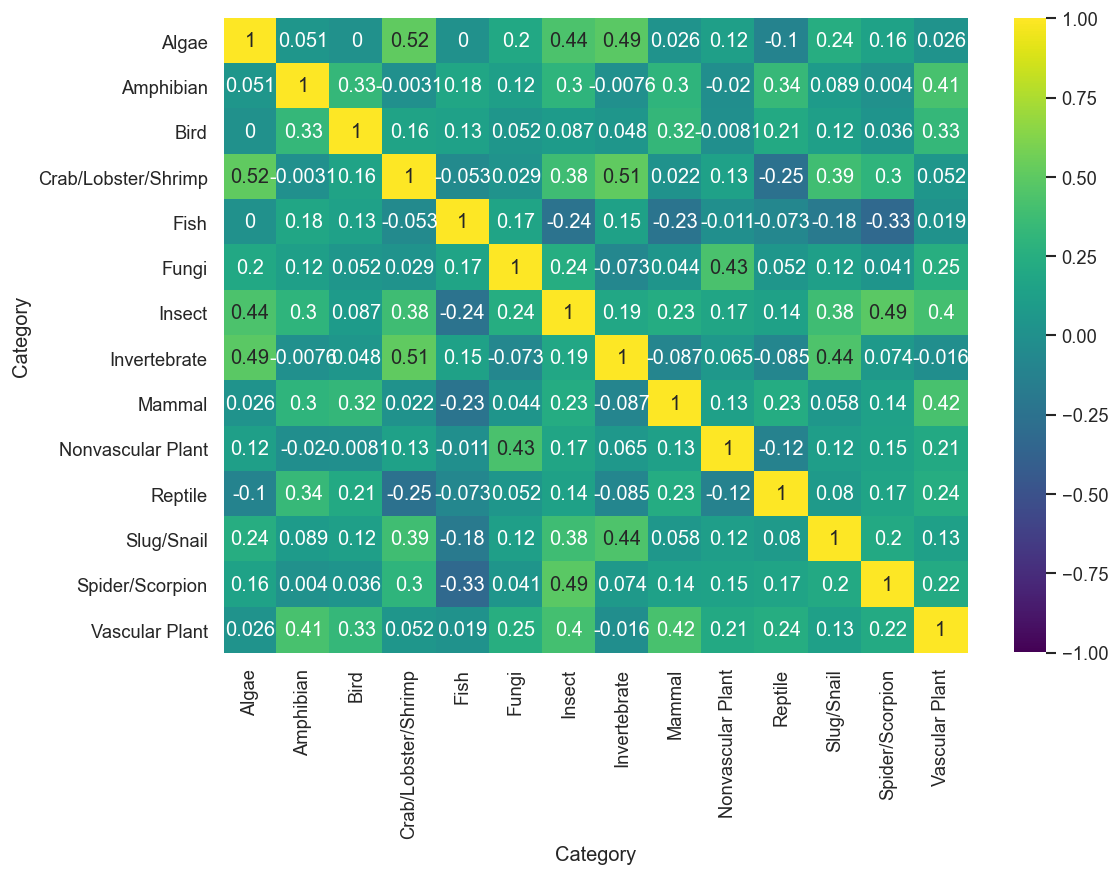

In [17]:
# Create a heatmap to visualize the correlation
corr_grid = pivoted_cat_park.corr(method='kendall')
plt.figure(figsize=(10,7), dpi=120)
sns.heatmap(
    corr_grid,
    xticklabels=corr_grid.columns, yticklabels=corr_grid.columns,
    vmax=1, center=0, vmin=-1,
    cmap='viridis',
    annot=True
)
plt.xlabel('Category')
plt.ylabel('Category')
plt.show()

As shown on the heatmap above, there are 7 pairs of groups that pass the threshold including:
- Crab/Lobster/Shrimp and Algae: 0.52
- Insect and Algae: 0.44
- Invertebrate and Algae: 0.49
- Invertebrate and Crab/Lobster/Shrimp: 0.51
- Nonvascular Plant and Fungi: 0.43
- Spider/Scorpion and Insect: 0.49
- Slug/Snail and Invertebrate: 0.44

I could say that the groups in each pair above have relative strong positive linear relation with one another, which means that the increase in the number of species of one group can cause another group to increase. However, this statement can always be proved incorrect in a further analysis.

## III. Conclusion

In this project, I've tried to visulize data in several different ways first to conduct EDA and second to test two hypotheses. As for exploratory data analyses, I found out some interesting facts regarding the species richest national parks in the United States, Great Smoky Mountains, Redwood, Shenandoah and Death Valley. In the United States, it seems easier for a national park visitor to observe a different species of Vascular Plant, Bird, or Insect in comparison with other species of other groups. Moreover, Bird, Vascular Plant and Mammal are three groups whose most number of species in conservation, which means that the animals and plants in these groups should be made known to visitors and others to support the conservation effort. 

In addition, the hypothesis test on the association between location and species richness shows a weak or almost no linear correlation between the two. However, I hypothesize that this weak correlation is due to the lack of data, and a similar future hypothesis test should be conduct when there is more data from other regions rather than only from US national parks. 

Last but not least, the second hypothesis test on the relationships between different groups confirms my knowledge that different species in the same regions are interconnected. Yet, I have my low confidence for this result since the connections between species follow many intricate patterns. 

## IV. Appendix

#### A. The complete US national parks species richness rankings

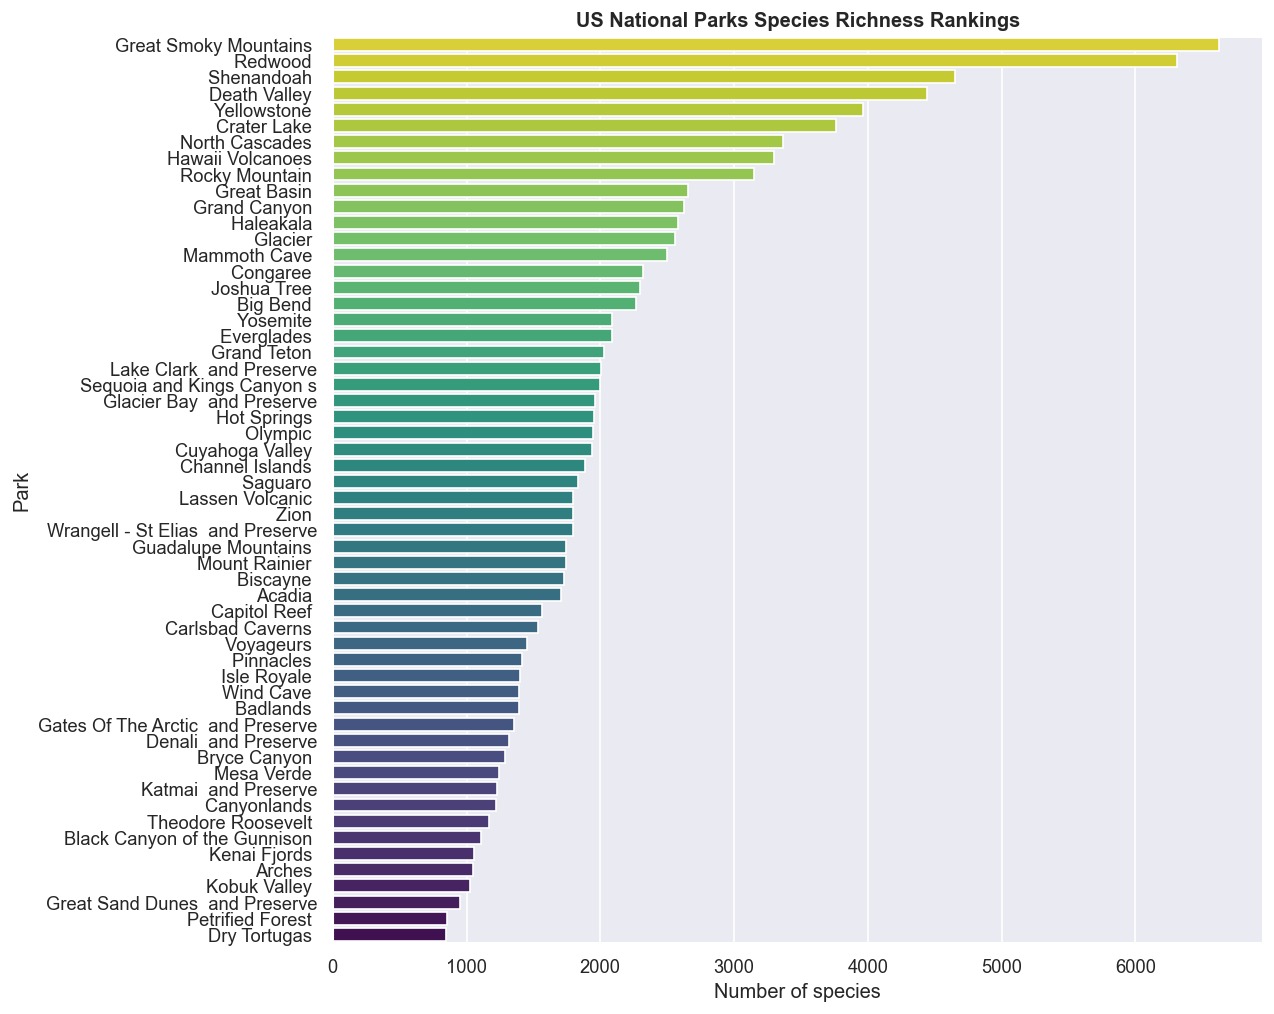

<Figure size 432x288 with 0 Axes>

In [18]:
## Create a new dataframe for number of species
park_ranking = park_species.groupby('park_name').scientific_name.count().reset_index()

## Sort parks based on number of species
park_ranking.sort_values(by='scientific_name', inplace=True)
park_ranking.columns = ['park_name', 'species_count']

# ## Plot a bar plot to compare the total numbers of species in each park
plt.figure(figsize=(10,10), dpi=120)
sns.barplot(x='species_count', y='park_name', data=park_ranking, palette='viridis')
plt.title('US National Parks Species Richness Rankings', weight='bold')
plt.ylabel('Park', fontsize=12)
plt.xlabel('Number of species', fontsize=12)
plt.gca().invert_yaxis()
plt.show()
plt.clf()

#### B. The distrubutions of latitude, longtitude and species richness

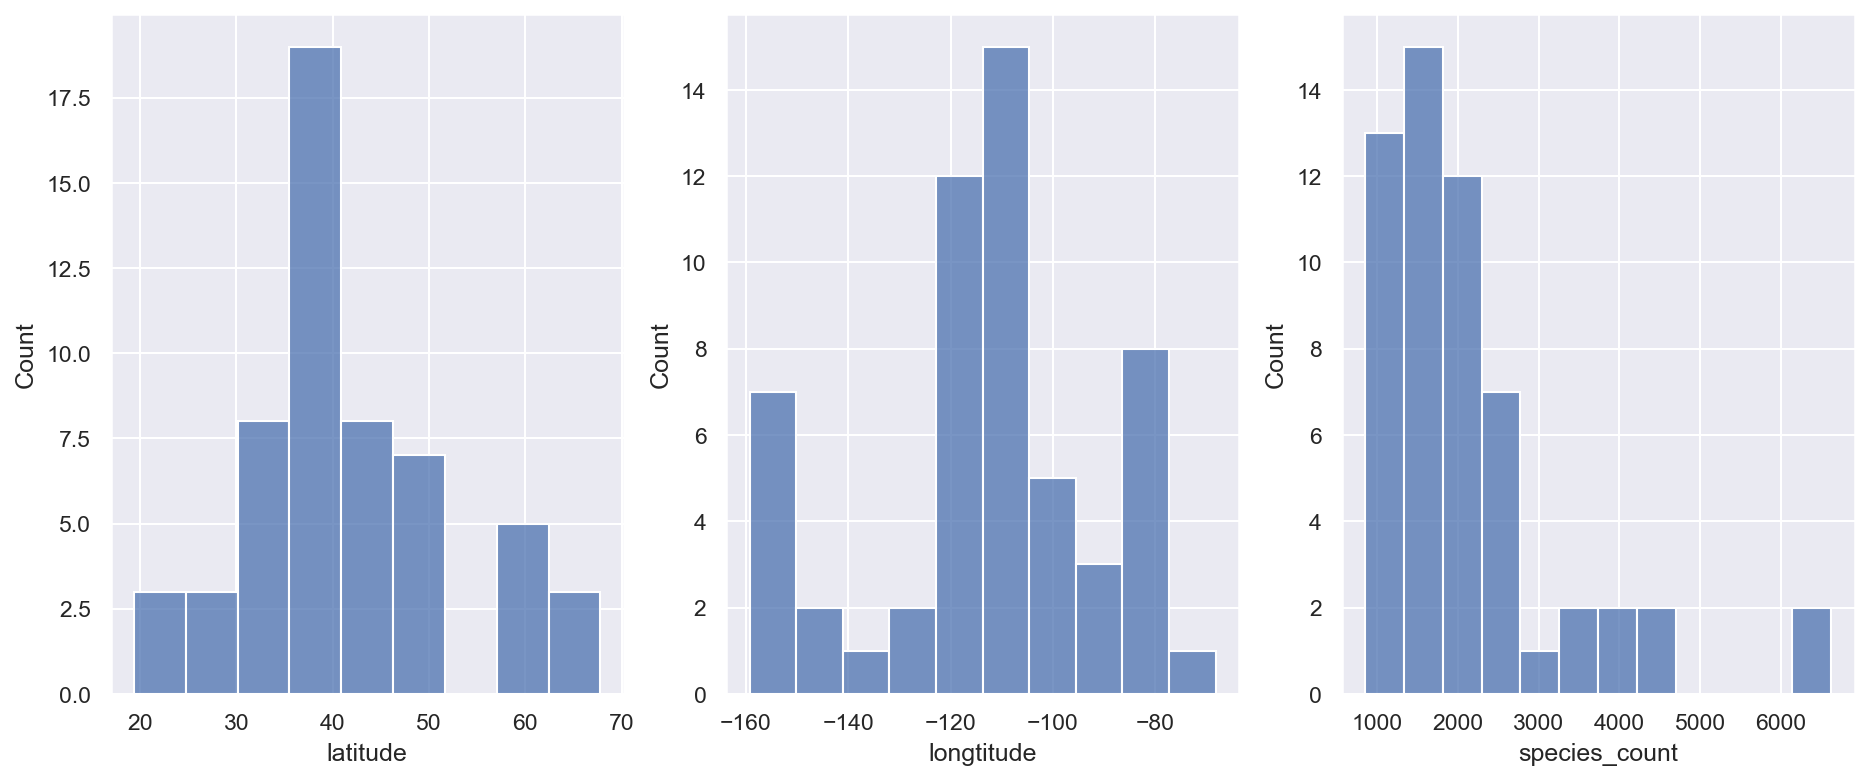

In [19]:
## Check the assumption of normality
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15,6), dpi=150)
vars = ['latitude', 'longtitude', 'species_count']
i=0
for var in vars:
    sns.histplot(lat_park[var], ax=axs[i])
    i +=1
plt.show()

#### C. The distributions of species group in 56 US national parks

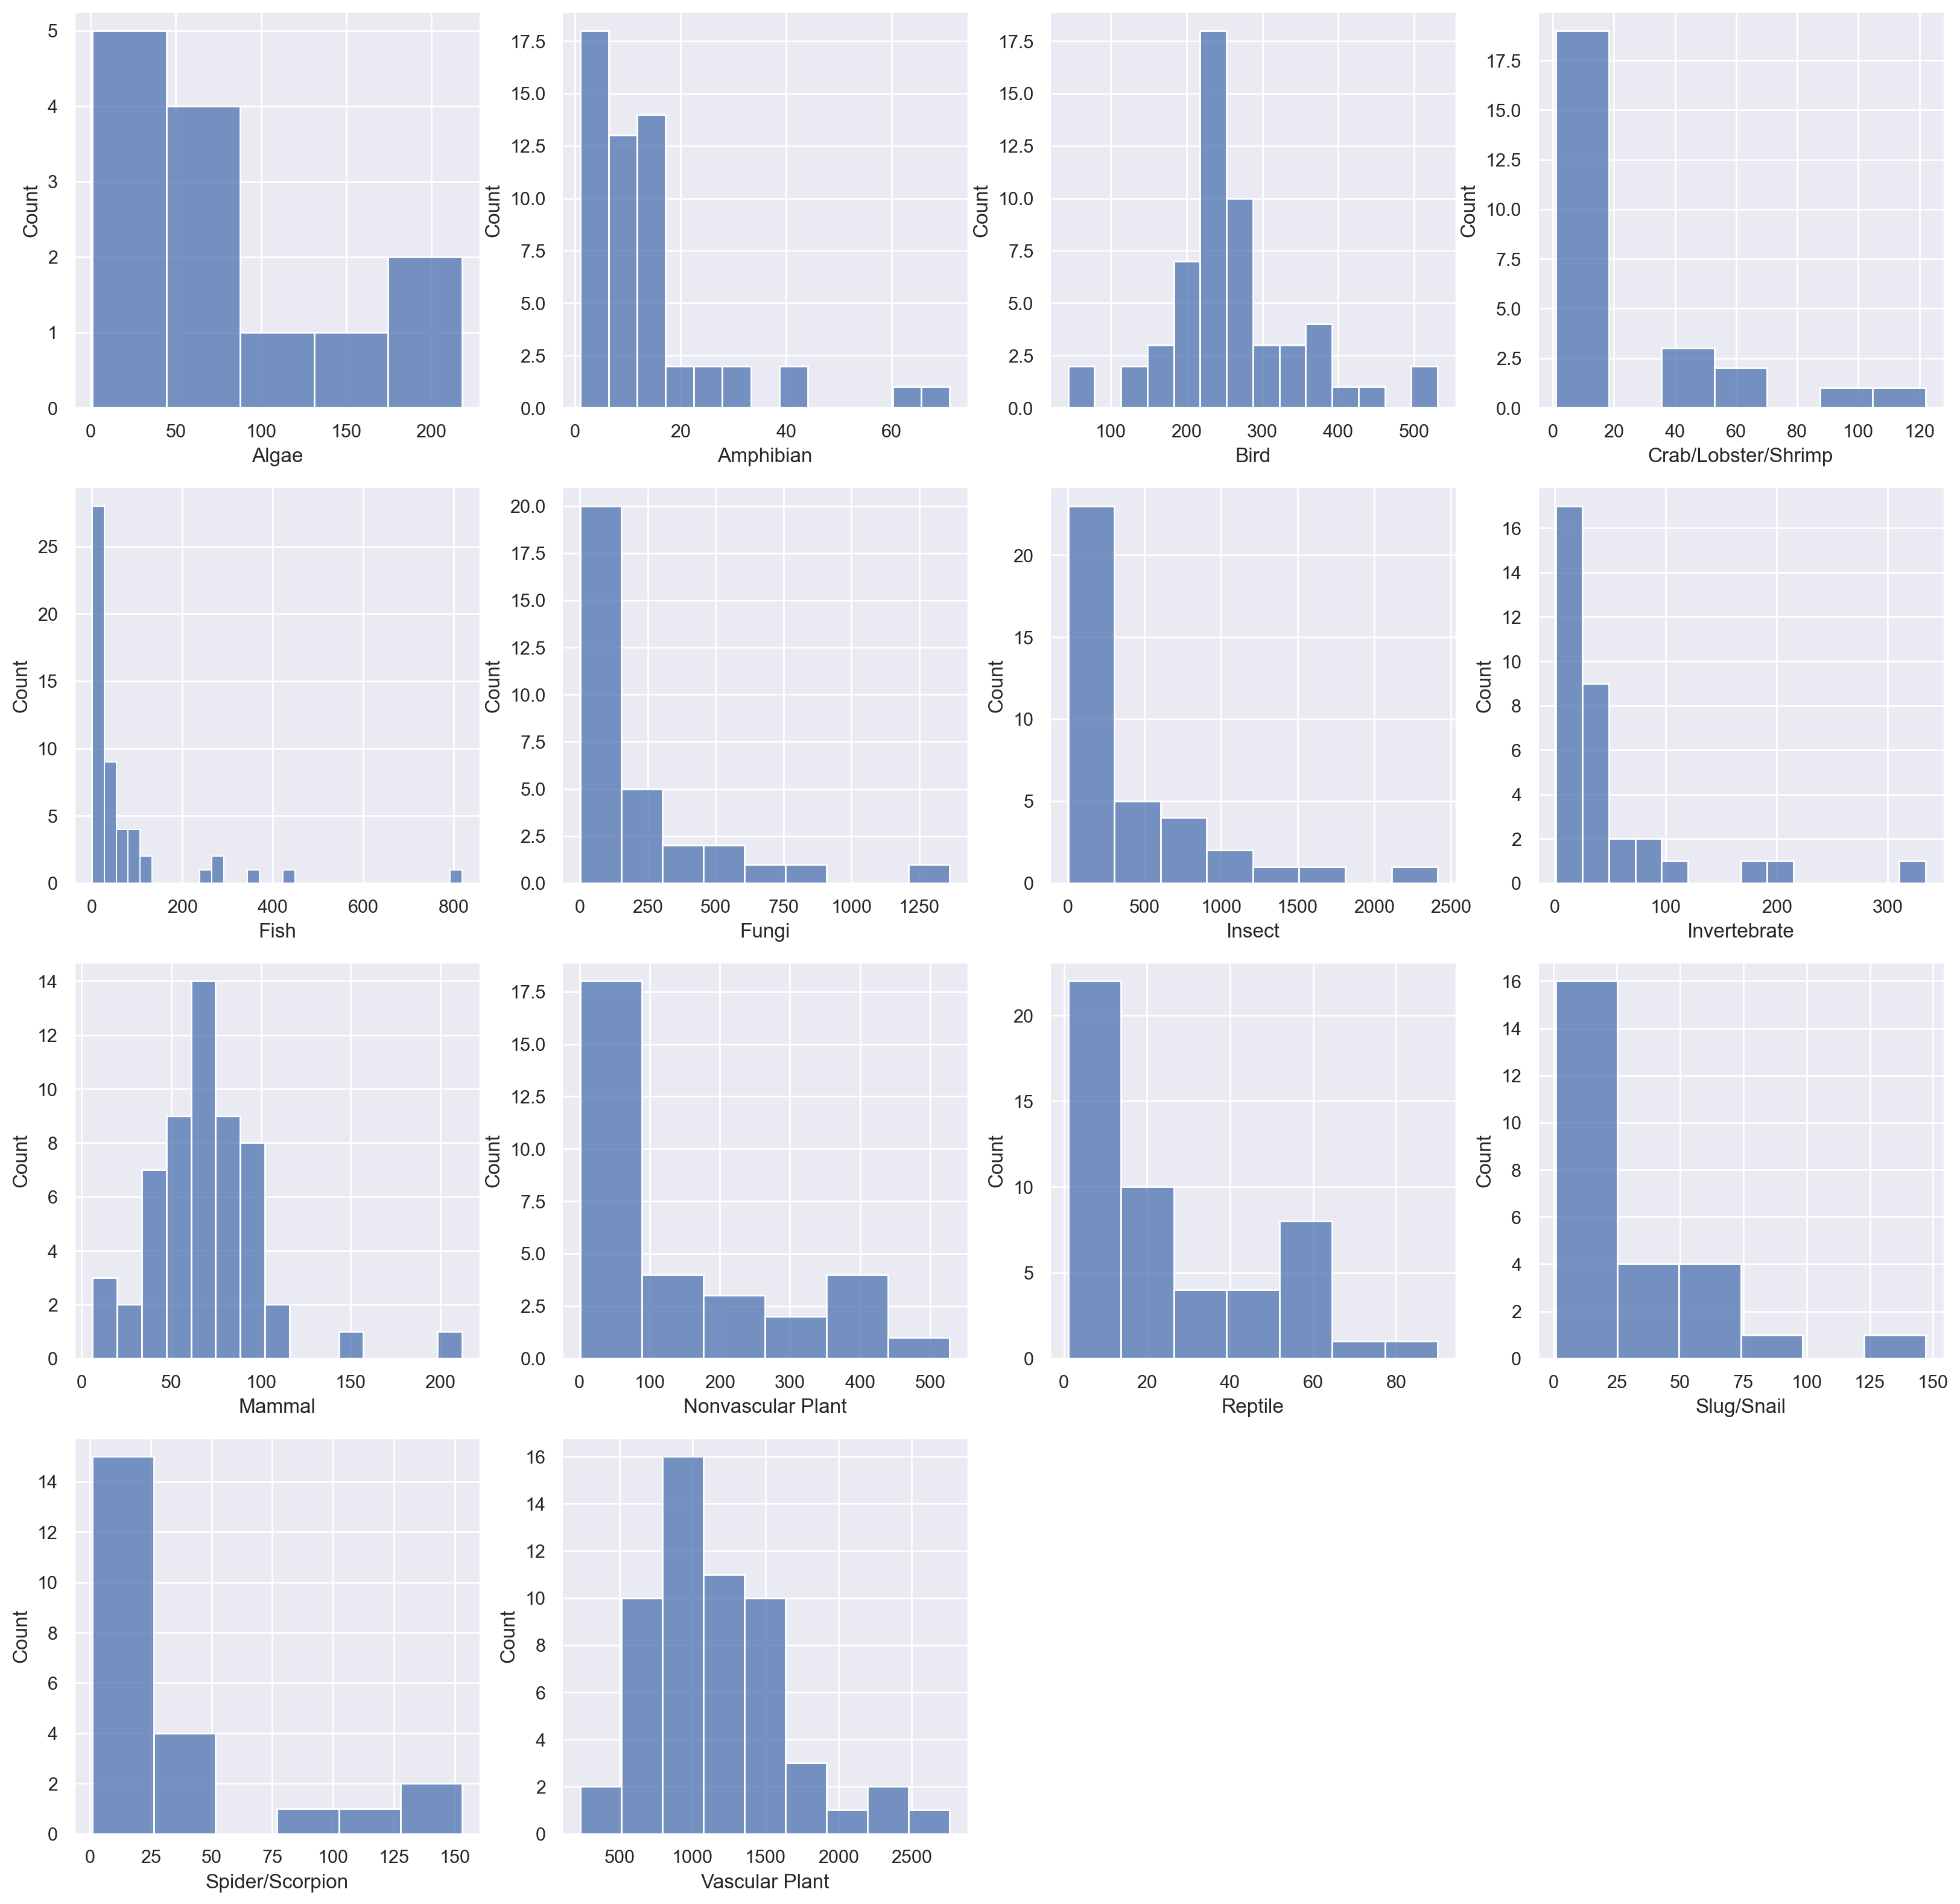

In [20]:
## Check the assumption of normality
i = 1
plt.figure(figsize=(20, 20), dpi=200)
for column in pivoted_cat_park.columns:
    plt.subplot(4,4,i)
    sns.histplot(pivoted_cat_park[column])
    i += 1
plt.show()